Lab 03 - Multinomial Logistic Regression 

$Name = "Muhammad Omer Farooq Bhatti"$
$Id = "st122498"$

## Multinomial Logistic Regression

This is logistic regression when number of classes are more than 2.

### Scratch

**Implementation steps:**
    
The gradient descent has the following steps:

1. Prepare your data
    - add intercept
    - $\mathbf{X}$ and $\mathbf{Y}$ and $\mathbf{W}$ in the right shape
        - $\mathbf{X}$ -> $(m, n)$
        - $\mathbf{Y}$ -> $(m, k)$
        - $\mathbf{W}$ -> $(n, k)$
        - where $k$ is number of classes
    - train-test split
    - feature scale
    - clean out any missing data
    - (optional) feature engineering
2. Predict using the softmax function
   $$ h = \mathsf{P}(y = a \mid \theta) = \frac{e^{\theta^{T}_ax}}{\Sigma_{i=1}^{k} e^{\theta_k^{T}x}}$$
   --->why this function?<----
   - First, mathematically, this is just an extension of the sigmoid formula for multi-class classification
   - $e$ will always give non-negative outputs which helps, since probability is never negative
   - $e$ has a similar effect as argmax, which will turn larger input to larger outputs.
   - $e$ is super easy to differentiate, because derivative of $e$ is $e$
   - $e$ nicely cancel out the $\log$ in the cross entropy loss (see below)
   - By dividing, it make sure all the probability adds up to one.  You can think the softmax function as some form of normalization.   Why not normalization?  Because normalization cares only about proportion, while softmax reacts to change in scale better.

3. Calculate the loss using the cross entropy loss
    $$J = -\sum_{i=1}^m y^{(i)}\log(h^{(i)})$$

4. Calculate the gradient of theta of feature $j$ based on the loss function $J$
    - The gradient is defined as
       $$\frac{\partial J}{\partial \theta_j} = \sum_{i=1}^{m}(h^{(i)}-y^{(i)})x_j$$
    - This gradient can be derived from the following simple example:
        - Suppose given 2 classes (k = 2) and 3 features (n = 3), we have the loss function as
       $$ J = -y_1 \log h_1 - y_2 \log h_2 $$
       where $h_1$ and $h_2$ are
       $$ h_1 = \frac{\exp(g_1)}{\exp(g_1)+\exp(g_2)} $$
       $$ h_2 = \frac{\exp(g_2)}{\exp(g_1)+\exp(g_2)} $$
       where $g_1$ and $g_2$ are
       $$ g_1 = w_{11}x_1 + w_{21}x_2 + w_{31}x_3 $$
       $$ g_2 = w_{12}x_1 + w_{22}x_2 + w_{32}x_3  $$
       where in $w_{ij}$, $i$ stands for feature and $j$ stands for class 
    - For example, to find the gradient of $J$ in respect to $w_{21}$, we simply can use the chain rule (or backpropagation) to calculate like this:
       $$ \frac{\partial J}{\partial w_{21}} = \frac{\partial J}{\partial h_{1}}\frac{\partial h_{1}}{\partial g_{1}}\frac{\partial g_{1}}{\partial w_{21}} + \frac{\partial J}{\partial h_{2}}\frac{\partial h_{2}}{\partial g_{1}}\frac{\partial g_{1}}{\partial w_{21}}$$
   - If we know each of them, it is easy, where
       $$\frac{\partial J}{\partial h_{1}} = -\frac{y_1}{h_1}$$
       $$\frac{\partial J}{\partial h_{2}} = -\frac{y_2}{h_2}$$
       $$\frac{\partial h_{1}}{\partial g_{1}} = \frac{\exp(g_{1})}{\exp(g_{1}) + \exp(g_{2})} - (\frac{\exp(g_1)}{\exp(g_1)+\exp(g_2)})^2 = h_1 (1 - h_1)$$
       $$\frac{\partial h_{2}}{\partial g_{1}} = \frac{-exp(g_2)exp(g_1)}{(\exp(g_1) + \exp(g_2)^2} = -h_2h_1$$
       $$\frac{\partial g_1}{\partial w_{21}} = x_2$$
    - For those who forgets how to do third and fourth, recall that the quotient rule
        $$ (\frac{f}{g})' = \frac{f'g - fg'}{g^2}$$
    - Putting everything together, we got
$$
\begin{aligned}
\frac{\partial J}{\partial w_{21}} &= \frac{\partial J}{\partial h_{1}}\frac{\partial h_{1}}{\partial g_{1}}\frac{\partial g_{1}}{\partial w_{21}} + \frac{\partial J}{\partial h_{2}}\frac{\partial h_{2}}{\partial g_{1}}\frac{\partial g_{1}}{\partial w_{21}}\\
&= -\frac{y_1}{h_1} * h_1 (1 - h_1) * x_2 + -\frac{y_2}{h_2} * -h_2h_1 * x_2 \\
&= x_2 (-y_1 + y_1h_1 + y_2h_1)\\
&= x_2 (-y_1 + h_1(y_1 + y_2))\\
&= x_2 (h_1 - y_1)\\
\end{aligned}
$$
4. Update the theta with this update rule
    $$\theta_j := \theta_j - \alpha * \frac{\partial J}{\partial \theta_j}$$
    where $\alpha$ is a typical learning rate range between 0 and 1
5. Loop 2-4 until max_iter is reached, or the difference between old loss and new loss are smaller than some predefined threshold tol

In [51]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [63]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from time import time
import random

In [53]:
class logisticRegression:
    def __init__(self, X, y, k, l_rate = 0.001):
        self.X_train = X
        self.m = self.X_train.shape[0]  # no.of samples
        self.n = self.X_train.shape[1]  # no. of features
        self.k=k
        Y_train_encoded = np.zeros((self.m, self.k))
        self.time_taken=0
                                   
        for n_class in range(self.k):
            cond = y==n_class
            Y_train_encoded[np.where(cond), n_class] = 1
        self.Y_train = Y_train_encoded      #One hot encoded Y_training data
        
        self.W = []
        self.alpha=l_rate
        self.method='mini-batch'
        
    def fit(self, max_iter=10000, method='mini-batch' ):
        self.method = method
        plt.figure(figsize=(8,5))
        
        self.W, i = self.logistic_regression_GD(self.X_train, self.Y_train, 
                                        self.k, self.X_train.shape[1], max_iter)
        
        
        
    def logistic_regression_GD(self, X, Y, k, n, max_iter):
        '''
        Inputs: 
            X shape: (m, n)
            w shape: (n, k)
        '''
        start_time = time()
        W = np.random.rand(n, k)
        J_iter=np.zeros(max_iter)
        
        if (self.method == "batch"):
            #Batch Gradient Descent
            xtrain = X
            ytrain = Y
            
            for i in range(max_iter):
                #Predict h_theta and gradient using initial value of W
                cost, grad =  self.gradient(xtrain, ytrain, W)
                J_iter[i]= cost
                
                #Update value of W
                W = W - self.alpha * grad
        
        elif (self.method == "mini-batch"):
            #Mini-Batch Gradient Descent
            batch_size = int(0.1*(X.shape[0]))
            for i in range(max_iter):
                xtrain, ytrain = self.get_minibatch(batch_size, X, Y)
                
                #Predict h_theta and gradient using initial value of W
                cost, grad =  self.gradient(xtrain, ytrain, W)
                J_iter[i]= cost
                
                #Update value of W
                W = W - self.alpha * grad
                
        elif (self.method == "sto"):
            #Stochastic Gradient Descent
            used_indexes=[]
            for i in range(max_iter):
                
                xtrain, ytrain, used_indexes = self.get_data_stochasticGD(X, Y, used_indexes)
                
                #Predict h_theta and gradient using initial value of W
                cost, grad =  self.gradient(xtrain, ytrain, W)
                J_iter[i]= cost
                
                #Update value of W
                W = W - self.alpha * grad
        else:
            raise ValueError(f"The value given for method argument (method = {self.method}) is not valid.")
        
        self.time_taken = time()-start_time
        self.plot_J_iter(J_iter,i)
        return W, i

    def get_minibatch(self, batch_size, X, y):
        index=np.random.randint(0,X.shape[0]) #choose a contiguous block of samples 
        xtrain=X[index:index+batch_size]      #of sizs = batch_size at random
        ytrain=y[index:index+batch_size]
        return xtrain, ytrain
    
    def get_data_stochasticGD(self, X, Y, used_indexes):
        n=np.random.randint(0, X.shape[0])
        while n in used_indexes:
            n=np.random.randint(0, X.shape[0])
        used_indexes.append(n)
        if ( len(used_indexes) == X.shape[0] ):
            used_indexes=[]
        xtrain=X[n,:].reshape(1,-1)
        ytrain=np.array([Y[n]])
        return xtrain, ytrain, used_indexes
                
        
    def plot_J_iter(self, J_iter, n_iter):
        #plt.figure(figsize=(10,10))
        plt.plot(np.arange(1,n_iter,1), J_iter[0:n_iter-1])
        plt.xlabel("Number of iterations")
        plt.ylabel("Loss")
        plt.title(f"{self.method} Gradient Descent - Loss vs Iterations Graph")
        
    def gradient(self, X, Y, W):
        m = X.shape[0]
        h = self.h_theta(X, W)
        cost = - np.sum(Y * np.log(h)) / m
        error = h - Y
        grad = self.softmax_grad(X, error)
        return cost, grad
    
    def softmax(self, theta_t_x):
        return np.exp(theta_t_x) / np.sum(np.exp(theta_t_x), axis=1, keepdims=True)

    def softmax_grad(self, X, error):
        return  X.T @ error
        
    def h_theta(self, X, W):
        '''
        Input:
            X shape: (m, n)
            w shape: (n, k)
        Returns:
            yhat shape: (m, k)
        '''
        return self.softmax(X @ W)

    def predict(self, X_test):
        h_test = self.h_theta(X_test, self.W)
        yhat = np.argmax(h_test, axis=1)
        return yhat


In [73]:
#Test Train Split
def tt_split(X, y, test_size = 0.3):
    
    index = range(0, X.shape[0])
    random_list = random.sample( index, int(test_size*X.shape[0]) )
    train_list = [i for i in index if i not in random_list]
    np.random.shuffle(train_list)
    #print(train_list)
    xtrain = X[train_list]
    ytrain = y[train_list]
    xtest = X[random_list]
    ytest = y[random_list]
    #print(ytrain)
    #print(ytest)
        
    return xtrain, xtest, ytrain, ytest

#Add intercept column
def add_intercept_column(_X):
        #Concatenating the intercept to training set as variable b of shape = (no. of samples used for training, 1)
        b=np.ones((_X.shape[0],1))
        _X = np.concatenate((b, _X), axis=1)
        
        return _X
    

In [78]:


#Prepare data

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, 2:]  # we only take the first two features.  #n=2
y = iris.target  #now our y is three classes thus require multinomial   #k=3 

# feature scaling helps improve reach convergence faster
scaler = StandardScaler()
X = scaler.fit_transform(X)

# data split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_test, y_train, y_test = tt_split(X, y, test_size=0.3)
print(f"from {X.shape} we sample {X_train.shape} for training and {X_test.shape} for testing.")

# add intercept to our X
X_train = add_intercept_column(X_train)
X_test = add_intercept_column(X_test)

# make sure our y is in the shape of (m, k)
# we will convert our output vector in 
# matrix where no. of columns is equal to the no. of classes. 
# The values in the matrix will be 0 or 1. For instance the rows 
# where we have output 2 the column 2 will contain 1 and the rest are all 0.
# in simple words, y will be of shape (m, k)
  # no. of class  (can also use np.unique)

#print(y_test.shape)




from (150, 2) we sample (105, 2) for training and (45, 2) for testing.


=========Classification report=======

---------------------------------------

Time taken to run the batch algorithm is 0.5619299411773682 seconds.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.89      0.94        19
           2       0.89      1.00      0.94        16

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45

---------------------------------------

---------------------------------------

Time taken to run the mini-batch algorithm is 0.525498628616333 seconds.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.89      0.94        19
           2       0.89      1.00      0.94        16

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.

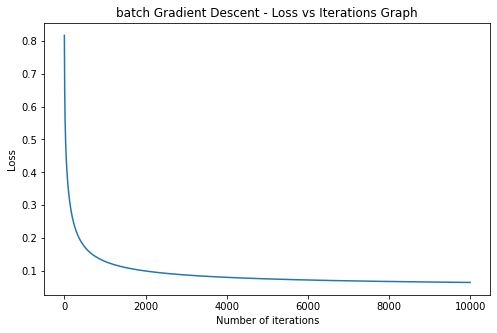

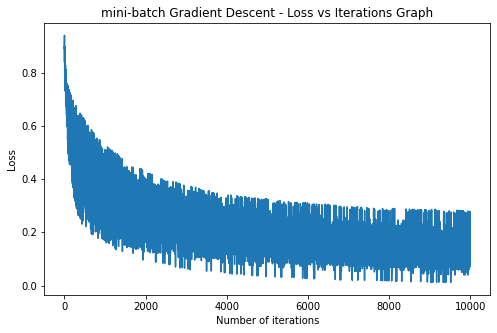

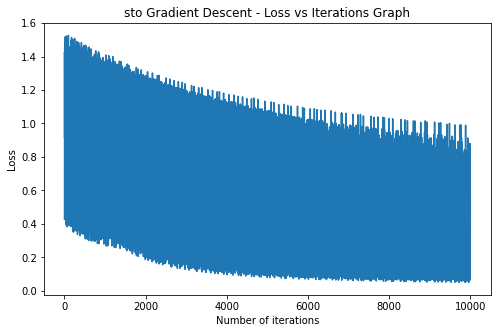

In [83]:
model = logisticRegression(X_train, y_train, k = len(set(y)))
classification_reports = {}
time_taken = {}
methods = ["batch", "mini-batch", "sto"]
print("=========Classification report=======\n")
for GD_method in methods:
    model.fit( max_iter = 10000, method = GD_method)
    yhat = model.predict(X_test)
    time_taken[GD_method] = model.time_taken
    classification_reports[GD_method] =  classification_report(y_test, yhat)
    print("---------------------------------------\n")
    print(f"Time taken to run the {GD_method} algorithm is {time_taken[GD_method]} seconds.\n")
    print(classification_reports[GD_method])
    print("---------------------------------------\n")
    

#print("Report: ", classification_report(y_test, yhat))

RESULTS:

In the above results we see that the time taken to run the algorithm is largest for Stochastic Gradient Descent and smallest for Mini-Batch Gradient Descent. 

The accuracy metric is the same for Batch GD and Mini-batch GD at 96%. However it is much lower for Stochastic GD at 84%. 

The training losses for Batch GD are very stable and we see a steady decline because all of training samples are used for each iteration in computing the gradient and loss. However, in case of Mini-Batch GD we see a choppy figure, where the losses are much less stable. This is because for each iteration we take a subset of training values to compute the gradient and loss function. However the general trend is still towards overall decline in losses as iterations increase. For Stochastic GD, the graph is even less stable and we see the loss jump from low to high from one iteration to the next as a single training sample is taken at random to compute the gradient and loss. The general trend line however still moves towards an overall decline in losses as number of iterations increase.

Given the above, it can easily be observed that Mini-batch GD should be the preferred algorithm since it has lowest running times and it ties Batch GD for accuracy in this case. The losses are not as stable between iterations as Batch GD and not as bad as Stochastic GD. 

In [80]:
model = logisticRegression(X_train, y_train, k = len(set(y)))
model.fit( method = "htr")

ValueError: The value given for method argument (method = htr) is not valid.

<Figure size 576x360 with 0 Axes>

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize

model = LogisticRegression(multi_class="ovr")  #set this to multiclass="ovr" to perform multinomial logistic

model.fit(X_train, y_train)
yhat = model.predict(X_test)

In [82]:
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))

=========Classification report=======
Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.89      0.94        19
           2       0.89      1.00      0.94        16

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45

